# Plot search metrics and other dynamical measures as a function of one or more filament parameters
Examples
- Unique location sampling rate vs parameter
- Filament behavior (periodic, aperiodic etc.) vs parameter
- ...

In [2]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pyfilaments.analysisutils as analysis
from pyfilaments._def_analysis import *
import pandas as pd
import h5py

from joblib import Parallel, delayed
import multiprocessing
%matplotlib notebook
plt.close('all')

# Figure parameters
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import cm
from tqdm import tqdm

rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 14})

# Create a folder for storing Publication figures

publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures/Figure2'


# Set the values for the publication figure parameters
rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 14})
sns.set(font_scale = 1)

linux system
dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', '

In [3]:
# Specify folder which to analyze

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep']

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep_RandomAnglesIC']

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23']

data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23']

In [5]:
# Find all analysis data files and create a list
files_list = []
 # Walk through the folders and identify the simulation data files

for data_folder in data_folders:
    for dirs, subdirs, files in os.walk(data_folder, topdown=False):

        root, subFolderName = os.path.split(dirs)

        for fileNames in files:
            if(fileNames.endswith('csv') and fileNames[0] != '.' and 'analysis' in fileNames and 'ic' not in fileNames):
                files_list.append(os.path.join(dirs,fileNames))


print('No:of files: {}'.format(len(files_list)))

# Collect all data into a single data frame
df = pd.DataFrame({})

for file in files_list:
    
    df = df.append(pd.read_csv(file))
    

# Assign some categorical variables to the data
df['periodic dynamics'][df['periodic dynamics']==1] = True
df['periodic dynamics'][df['periodic dynamics']==0] = False
df['period'][pd.isna(df['period'])] = 'aperiodic'
df['period'][df['simulation completed']== False] = 'Escape'
df

No:of files: 400


/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,N particles,radius,bond length,spring constant,kappa_hat,force strength,stresslet strength,potDipole strength,simulation type,boundary condition 0,boundary condition 1,activity time scale,viscosity,period,threshold index,simulation completed,periodic dynamics,max unique locations,activity cycles completed
0,0,32,1,2.1,25,6.25,0,0,0.692308,point,clamped,free,750,0.166667,1,3,True,True,1.0,500
0,0,32,1,2.1,25,6.25,0,0,0.692308,point,clamped,free,750,0.166667,1,34,True,True,44.0,500
0,0,32,1,2.1,25,6.25,0,0,0.692308,point,clamped,free,750,0.166667,1,32,True,True,36.0,500
0,0,32,1,2.1,25,6.25,0,0,0.692308,point,clamped,free,750,0.166667,1,28,True,True,22.0,500
0,0,32,1,2.1,25,6.25,0,0,0.692308,point,clamped,free,750,0.166667,1,26,True,True,14.0,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,32,1,2.1,25,6.25,0,0,2.871795,point,clamped,free,750,0.166667,Escape,0,False,False,204.0,5
0,0,32,1,2.1,25,6.25,0,0,2.871795,point,clamped,free,750,0.166667,Escape,0,False,False,181.0,5
0,0,32,1,2.1,25,6.25,0,0,2.871795,point,clamped,free,750,0.166667,Escape,0,False,False,149.0,3
0,0,32,1,2.1,25,6.25,0,0,2.871795,point,clamped,free,750,0.166667,Escape,0,False,False,293.0,12


In [80]:
np.unique(df[parameter])

array([0.5       , 0.56410256, 0.62820513, 0.69230769, 0.75641026,
       0.82051282, 0.88461538, 0.94871795, 1.01282051, 1.07692308,
       1.14102564, 1.20512821, 1.26923077, 1.33333333, 1.3974359 ,
       1.46153846, 1.52564103, 1.58974359, 1.65384615, 1.71794872,
       1.78205128, 1.84615385, 1.91025641, 1.97435897, 2.03846154,
       2.1025641 , 2.16666667, 2.23076923, 2.29487179, 2.35897436,
       2.42307692, 2.48717949, 2.55128205, 2.61538462, 2.67948718,
       2.74358974, 2.80769231, 2.87179487, 2.93589744, 3.        ])

## 1. Filament behavior vs Parameter of Interest

<IPython.core.display.Javascript object>


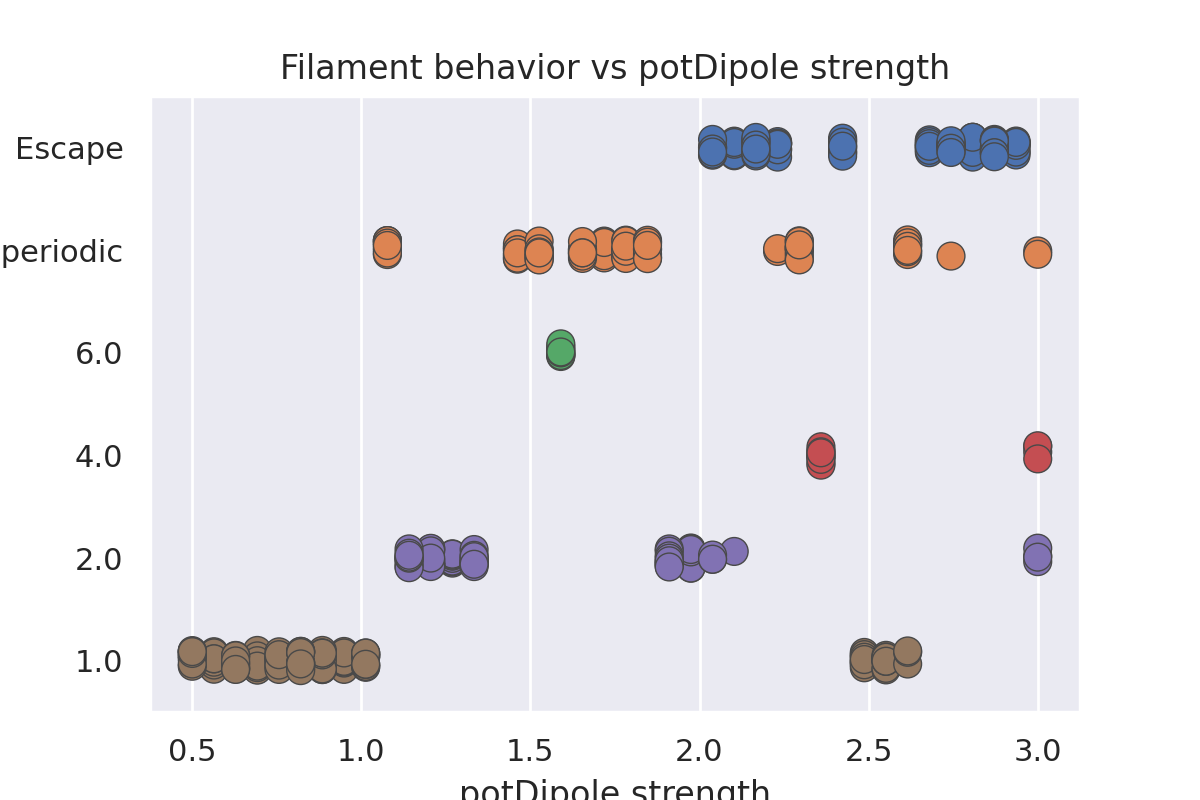

In [6]:
# Categorical Plot of Filament behavior vs Parameter value

parameter = 'potDipole strength'
save = True

title = 'Filament behavior vs {}'.format(parameter)
plt.figure(figsize=(6,4))
sns.stripplot(data = df, x = parameter, y = 'period', order = ['Escape', 'aperiodic',6.0, 4.0, 2.0, 1.0], size = 10, linewidth = 0.5)
plt.title(title)
plt.show()


<IPython.core.display.Javascript object>


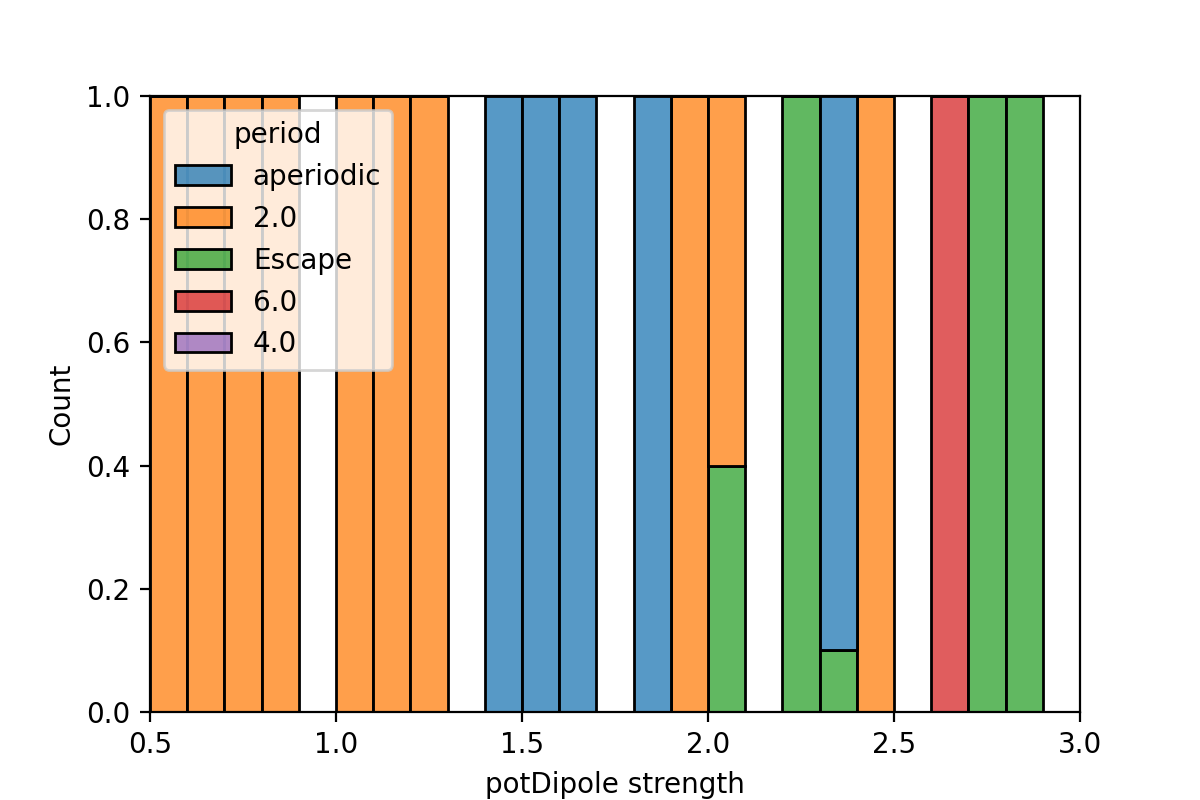

In [33]:
# Plot percent of IC leading to a certain behavior

parameter = 'potDipole strength'
save = True

title = 'Observation of filament behavior vs {}'.format(parameter)
plt.figure(figsize=(6,4))

sns.histplot(data = df, x = parameter, hue = 'period', multiple = 'fill', binwidth = 0.1)
plt.show()



## 2. Plot Max unique locations sampled vs Activity strength

<IPython.core.display.Javascript object>


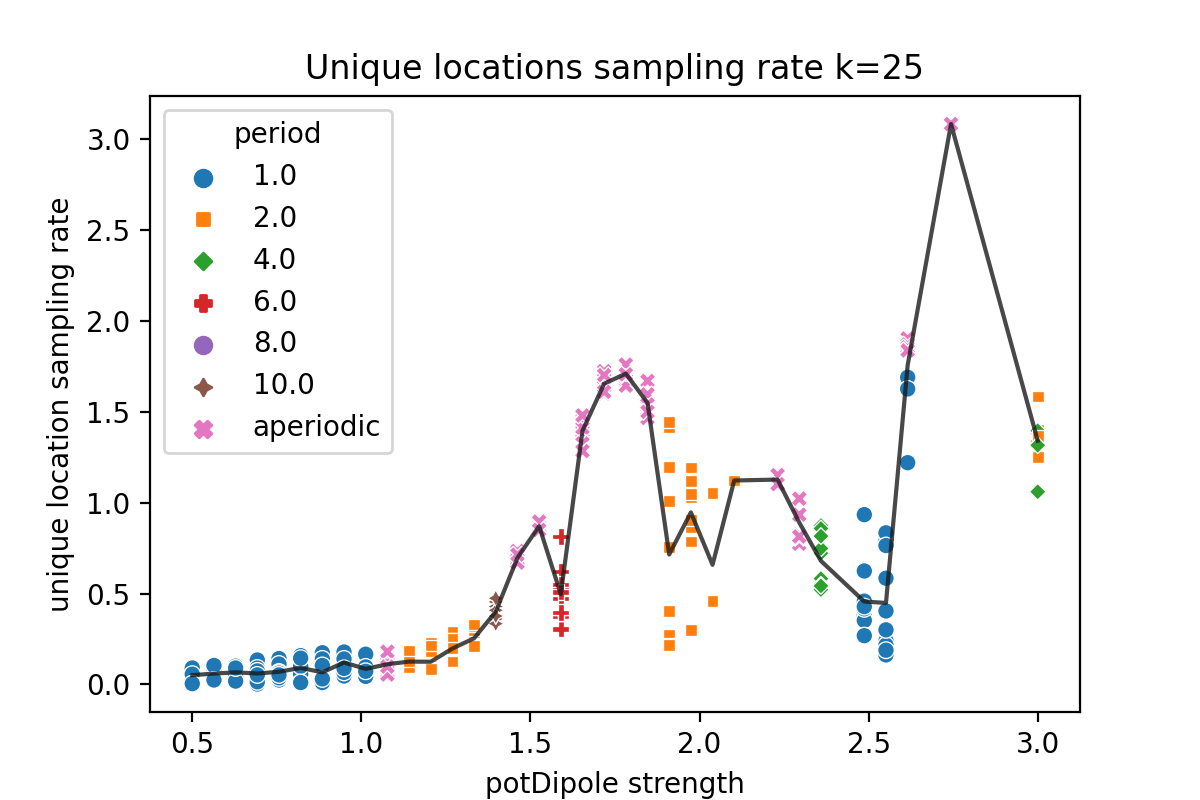

In [7]:
parameter = 'potDipole strength'
save = False

# Take subset of data for which simulation was completed
df_subset = df.loc[df['simulation completed']==True]

df_subset = df_subset.loc[df_subset[parameter]<=3.0]

plt.style.use('default')

df_subset['unique location sampling rate'] = df_subset['max unique locations']/df_subset['activity cycles completed']

note = 'random-angle-IC'
title = 'Unique locations sampling rate k={}'.format(np.array(df['spring constant'][:])[0])
plt.figure(figsize=(6, 4))
# ax = sns.lineplot(data=df, x= 'potDipole strength', y= 'max unique locations', ci=None, markers=False, dashes = False, color = 'k')

# ax1 = sns.lineplot(data=df_subset, x= 'potDipole strength', y= 'unique location sampling rate', style=" activity time scale", markers=None, ci=95, err_style = 'bar', err_kws= {'capsize':3, 'elinewidth':1, 'ecolor':'r'}, markerfacecolor='r', markeredgecolor='w', color = 'k', alpha =0.8, legend = False)
ax1 = sns.lineplot(data=df_subset, x= parameter, y= 'unique location sampling rate', style=" activity time scale", markers=None, ci=None, err_style = 'band', markerfacecolor='r', markeredgecolor='w', color = 'k', alpha =0.8, legend = False)

ax2 = sns.scatterplot(data=df_subset, x= parameter, y= 'unique location sampling rate', style="period", hue = 'period', hue_order = [1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 'aperiodic'])


# ax.set_xscale('log')
plt.title(title)

if (save):
    plt.savefig(os.path.join(publication_figures, title+note + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title+note + '.svg'), dpi = 300)
plt.show()

### Compare full simulations with Predicted Dynamics

<IPython.core.display.Javascript object>


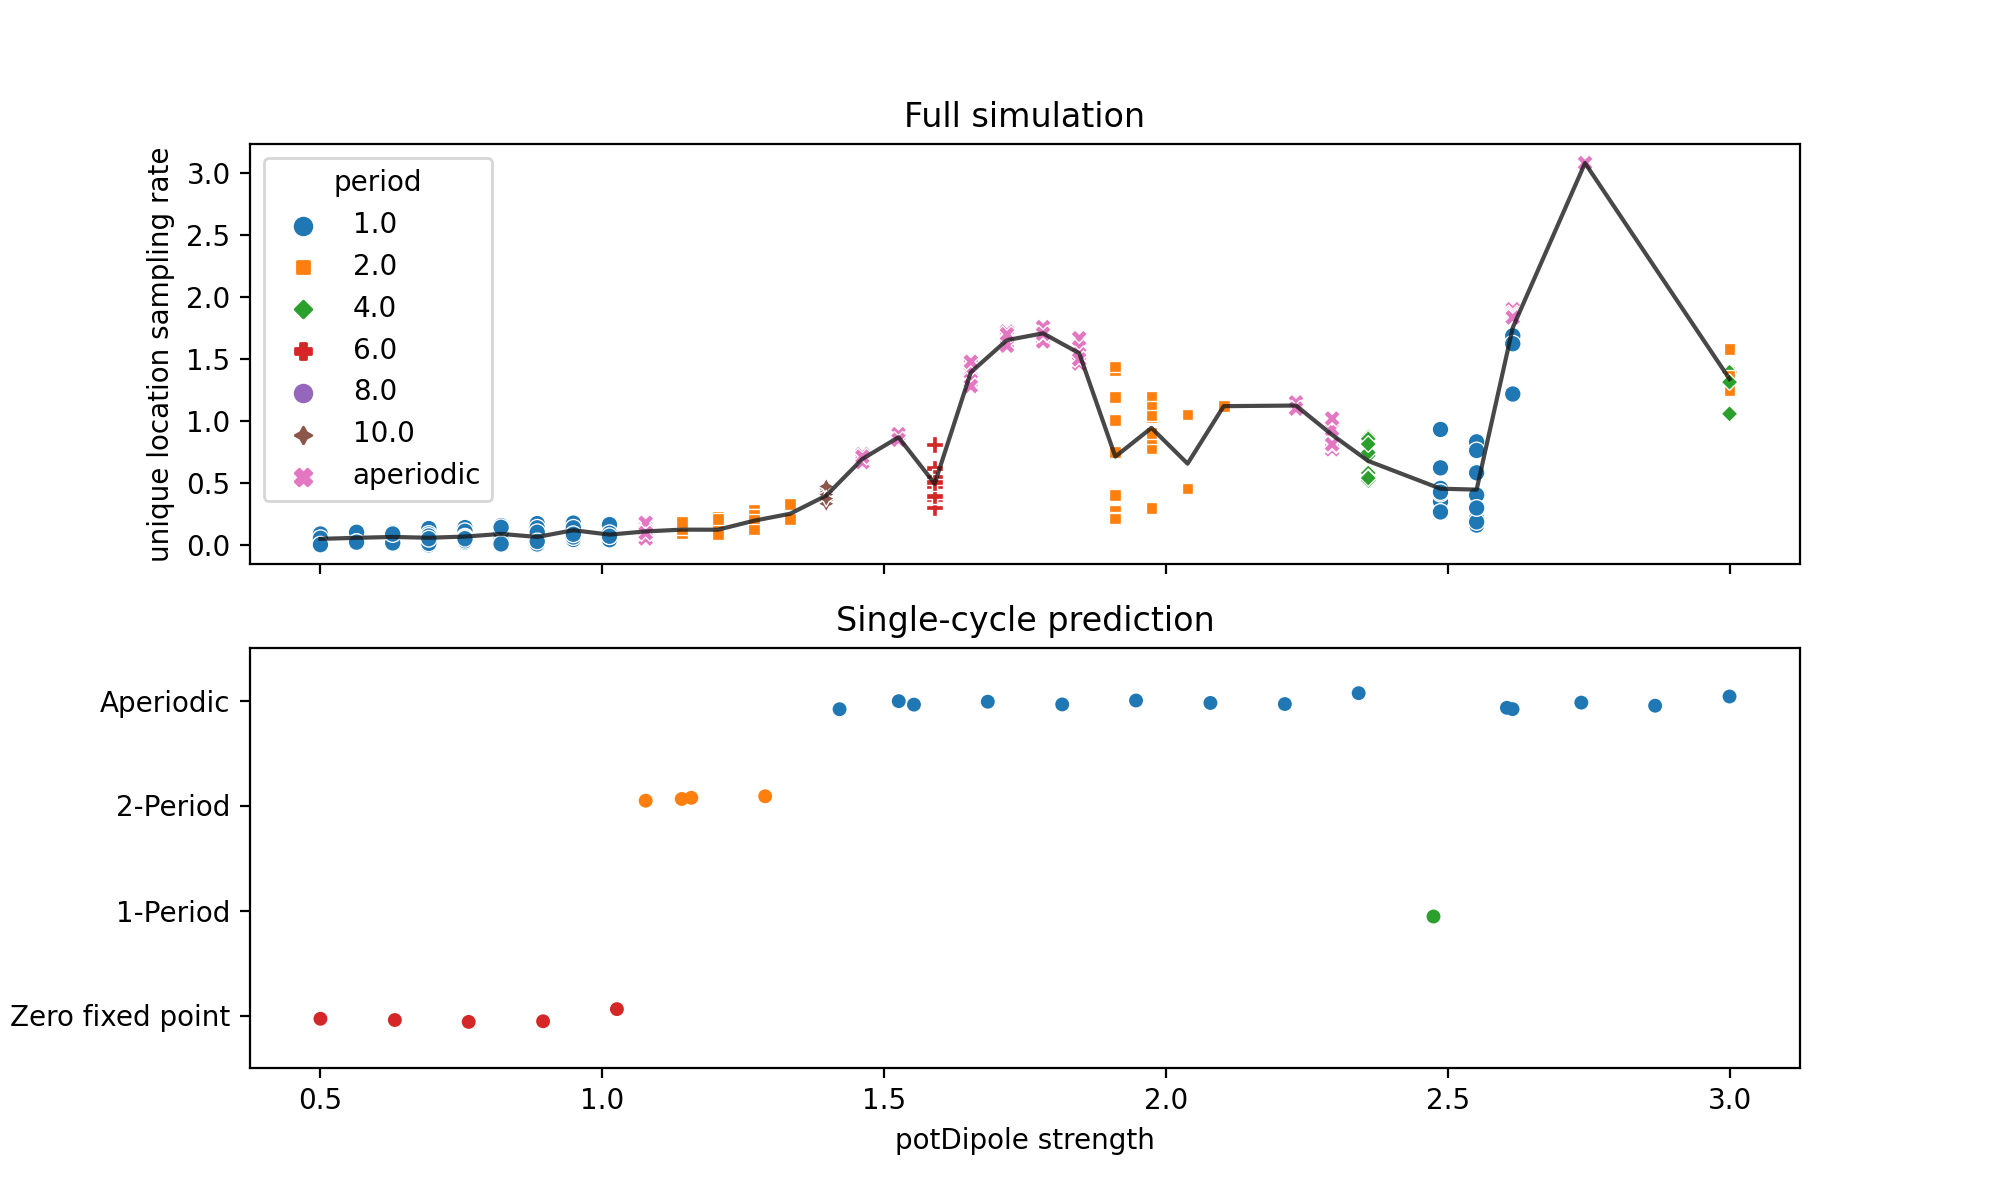

In [6]:
save = False 

predicted_dynamics = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_k_25_extension_first/PredictedDynamics/PredictedDynamics.csv'

df_predicted_dynamics = pd.read_csv(predicted_dynamics)

fig,(ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (10,6))
title = 'FullSimVsPredictedDynamics'
sns.lineplot(data=df_subset, x= parameter, y= 'unique location sampling rate', style=" activity time scale", 
             markers=None, ci=None, err_style = 'band', markerfacecolor='r', markeredgecolor='w', 
             color = 'k', alpha =0.8, legend = False, ax = ax0)

sns.scatterplot(data=df_subset, x= parameter, y= 'unique location sampling rate', style="period", 
                hue = 'period', hue_order = [1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 'aperiodic'], ax = ax0)

sns.stripplot(data = df_predicted_dynamics, x = parameter, y = 'Predicted dynamics', 
            order=["Aperiodic", "2-Period", "1-Period", "Zero fixed point"], ax = ax1)

ax0.title.set_text('Full simulation')
ax1.title.set_text('Single-cycle prediction')

# plt.title(title)

if (save):
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.show()





### Compare Full-simulations, Predicted Dynamics and Calculated Lyapunov exponents

<IPython.core.display.Javascript object>


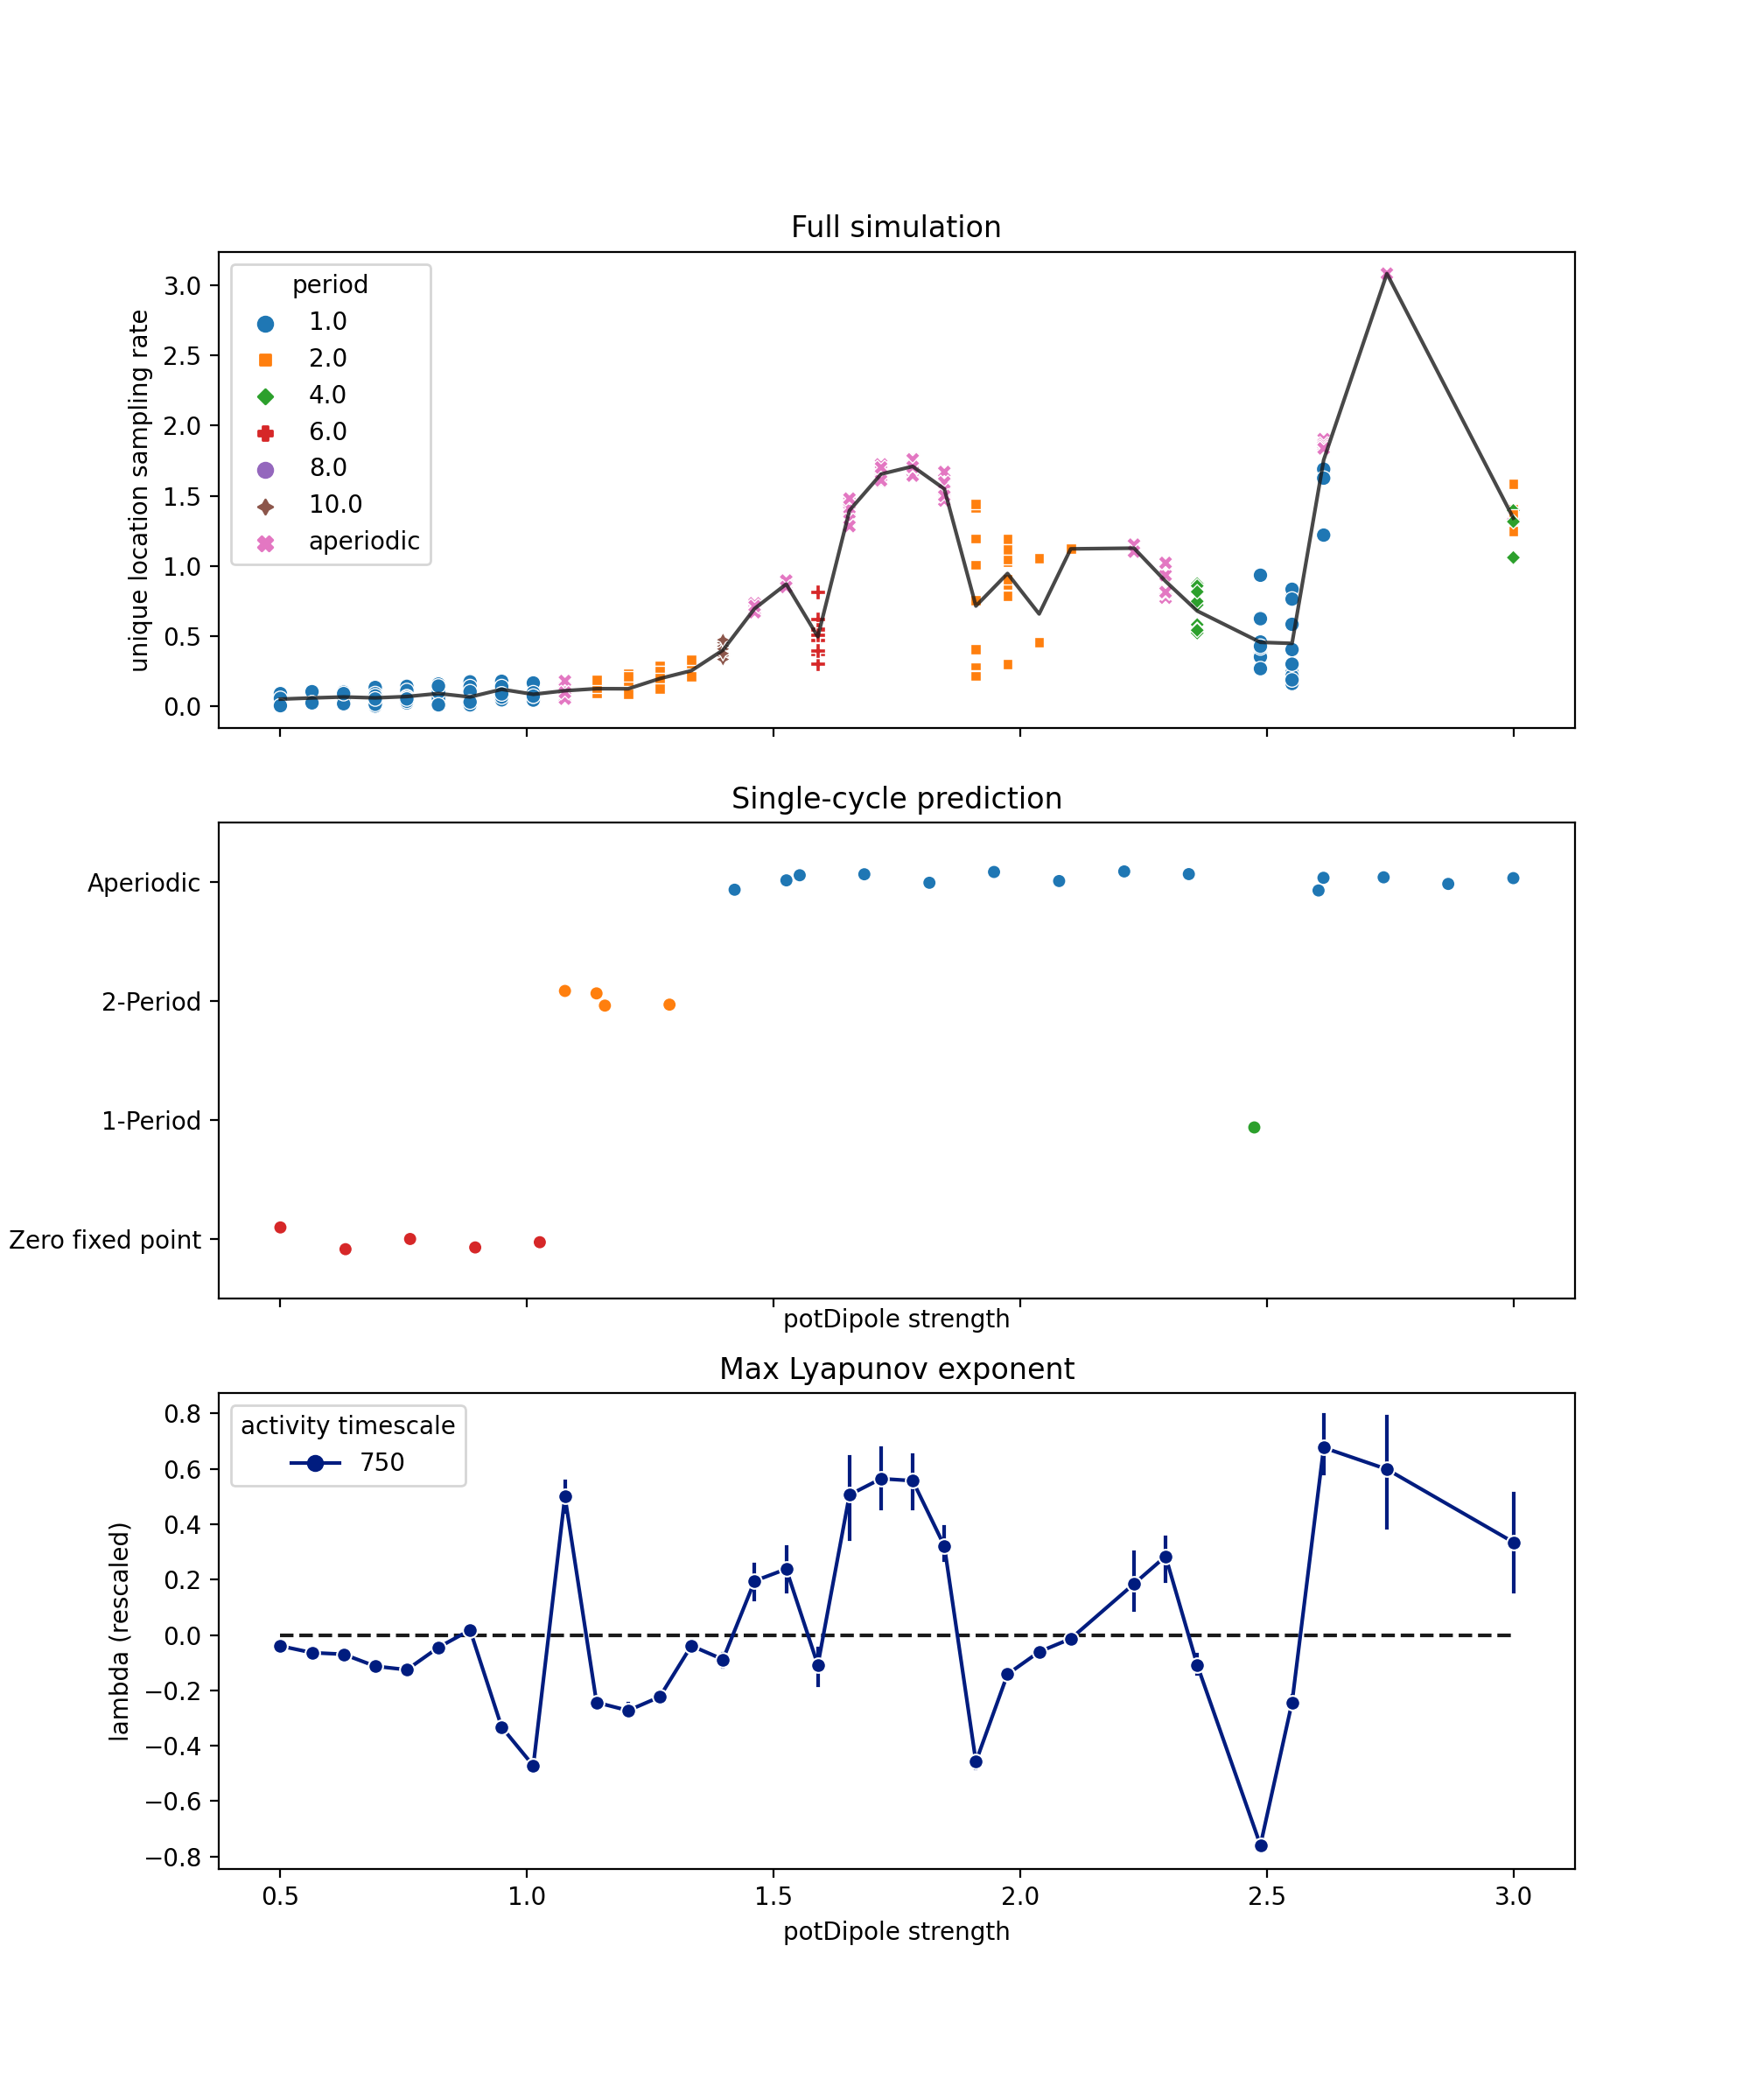

In [14]:
save = True 

predicted_dynamics = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_k_25_extension_first/PredictedDynamics/PredictedDynamics.csv'

df_predicted_dynamics = pd.read_csv(predicted_dynamics)

# Lyapunov exponent data
lyapunov_data = '/home/deepak/Dropbox/LacryModeling/processed_data/IC_sensitivity_analysis/lyapunov_exp_vs_potDipole strength.csv'

df_lyapunov = pd.read_csv(lyapunov_data)

fig,(ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize = (10,12))
title = 'FullSimVsPredictedDynamics_LyapunovExponent'
sns.lineplot(data=df_subset, x= parameter, y= 'unique location sampling rate', style=" activity time scale", 
             markers=None, ci=None, err_style = 'band', markerfacecolor='r', markeredgecolor='w', 
             color = 'k', alpha =0.8, legend = False, ax = ax0)

sns.scatterplot(data=df_subset, x= parameter, y= 'unique location sampling rate', style="period", 
                hue = 'period', hue_order = [1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 'aperiodic'], ax = ax0)

sns.stripplot(data = df_predicted_dynamics, x = parameter, y = 'Predicted dynamics', 
            order=["Aperiodic", "2-Period", "1-Period", "Zero fixed point"], ax = ax1)

sns.lineplot(data = df_lyapunov, x = parameter, y = 'lambda (rescaled)', style = 'activity timescale', 
             hue="activity timescale", err_style = 'bars', markers = True, palette = 'dark', ax=ax2)
ax2.hlines(y=0, xmin=min(df_lyapunov[parameter]),xmax=max(df_lyapunov[parameter]), linestyle = '--', color = 'k')

ax0.title.set_text('Full simulation')
ax1.title.set_text('Single-cycle prediction')
ax2.title.set_text('Max Lyapunov exponent')

# plt.title(title)

if (save):
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.show()

## 3. Unique locations sampled statistics

In [2]:
# Choose the data folder which we want to plot

data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23'

parameter_values_to_plot = [0.5, 1.0, 1.2, 1.78, 2.0, 2.4, 2.74]

In [3]:
# Interpolate time-series data into a common time array
n_times = 1000

# Data frame containing the ensemble data
df_ensemble = pd.DataFrame({})

# Metadata to save
# metadata_list = ['spring constant', 'kappa_hat','potDipole strength']

parameter = 'potDipole strength'
count = 1
# Find all simulation data files and create a list
files_list = []
 # Walk through the folders and identify the simulation data files
for dirs, subdirs, files in os.walk(data_folder, topdown=False):
       
    
    root, subFolderName = os.path.split(dirs)
    
 
    if('SearchCoverage' in subFolderName):
        # This filters data for which the unique position analysis has been completed. 
        
        root, *rest = os.path.split(root) # root is the top-level folder 2 layers up from subfolder
   
        # Get the metadata for this file
        df_metadata = pd.read_csv(os.path.join(root,'metadata.csv'))
           
       
        
#         plot_parameter_flag = np.any(abs(np.round(parameter_value,2)-parameter_values_to_plot) <= 0.05)
        plot_parameter_flag = True
    
        for file in files:
            
            if('unique_counts_timeseries' in file):
                
                analysis_file = file.replace('unique_counts_timeseries', 'analysis')
                
                analysis_file_path = os.path.join(root, 'Analysis',analysis_file)
                
                assert(os.path.exists(analysis_file_path))
                
                df_metadata = pd.read_csv(analysis_file_path)
                
                activity_timescale = df_metadata[' activity time scale'][0]
                sim_complete = df_metadata['simulation completed'][0]
        
                parameter_value = df_metadata[parameter][0]
            
                periodic_dynamics = df_metadata['periodic dynamics'][0]
                
                if(periodic_dynamics):
                    
                    period = int(df_metadata['period'][0])
                    
                else:
                    period = 'Aperiodic'
                    
            
                plot_parameter_flag = np.any(abs(parameter_value - parameter_values_to_plot)<=0.05)
                
                
                
                if(sim_complete and plot_parameter_flag):
               # Load the time-series data
                    df_current = pd.read_csv(os.path.join(dirs,file))
                    time = df_current['Time']
                    data = df_current['Unique positions count']

                    data_fun = interpolate.interp1d(time, data, kind = 'linear')

                    time_vect_sampled = np.linspace(np.min(time), np.max(time), n_times)

                    data_sampled = data_fun(time_vect_sampled)

    #                 temp_dict = {var : [np.repeat(df_metadata[var], n_times)] for var in metadata_list}

                    df_sampled = pd.DataFrame({'Time':time_vect_sampled, 'Initial condition': np.repeat(count, n_times),
                                               'Unique locations visited': data_sampled, 
                                               parameter:np.repeat(np.round(df_metadata[parameter],2), n_times), 
                                               'activity time scale':np.repeat(df_metadata[' activity time scale'], n_times), 'period': np.repeat(period, n_times)})


                    df_ensemble = df_ensemble.append(df_sampled)
                    count +=1 

print(count)



65


In [111]:
print(np.unique(df_ensemble[parameter]))

[0.5  1.01 1.21 1.78 1.97 2.04 2.36 2.74]


<IPython.core.display.Javascript object>


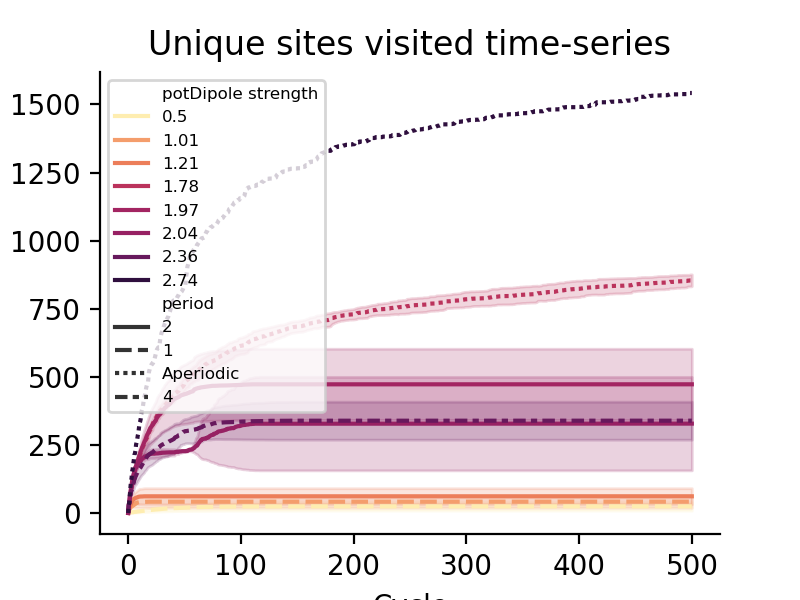

In [6]:
import cmocean
# Set the values for the publication figure parameters
rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 16})
sns.set(font_scale = 1)
# plt.style.use('dark_background')
plt.style.use('default')

title = 'Unique sites visited time-series'
plt.figure(figsize=(4,3))

sns.lineplot(data = df_ensemble, x = df_ensemble['Time']/df_ensemble['activity time scale'], 
             y = 'Unique locations visited', hue = parameter, style = 'period',
             ci = 'sd', palette = cmocean.cm.matter, legend = 'full')

plt.title(title)
plt.xlabel('Cycle')
# plt.yscale('log')
plt.legend(loc='best', prop={'size':6})
sns.despine(right=True, top=True)

plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)

plt.show()

## 4. Convex-hull of Unique Points vs Time 

Above we plotted the No:of unique locations of the filament tip. Now we look at a different but related metric: the convex-hull of the unique locations. This tells us how fast the filament samples the space around it. This also distinguishes between systematic vs stochastic sampling of space.  

,Unnamed: 0,ID,Time,Hits,Position X,Position Y,Position Z
0,0,0,0.0,30,52.727653,38.181207,0.0
1,1,1,20.0,47,50.970085,36.873615,0.0
2,2,2,70.0,64,49.310956,35.518895,0.0
3,3,3,100.0,71,47.775134,33.766284,0.0
4,4,4,120.0,50,45.491678,33.198749,0.0
...,...,...,...,...,...,...,...
848,848,848,362780.0,4,12.990454,-27.146557,0.0
849,849,849,362800.0,1,11.228153,-29.142196,0.0
850,850,850,362970.0,5,-1.561816,-44.721879,0.0
851,851,851,362990.0,2,-2.886873,-46.411694,0.0


In [ ]:
# Calculate the co

## 5. Distribution of First-passage Times vs Parameter

In [17]:
# Load the first passage time data
data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23'
parameter = 'potDipole strength'


In [28]:
# Find all simulation data files and create a list
files_list = []

df_fpt = pd.DataFrame({})
 # Walk through the folders and identify the simulation data files
count = 1
for dirs, subdirs, files in os.walk(data_folder, topdown=False):
       
    
    root, subFolderName = os.path.split(dirs)
 
    if('SearchCoverage' in subFolderName):
        
        root, *rest = os.path.split(root) # root is the top-level folder 2 layers up to subfolder
   
        # Get the metadata for this condition
        df_metadata = pd.read_csv(os.path.join(root, 'metadata.csv'))
        
        
        for file in files:
            if('unique_positions' in file):
                # Load the unique positions data
                
                
                df_unique_positions = pd.read_csv(os.path.join(dirs,file))
                hits_counter_keys, hits_counter_values = df_unique_positions['ID'], df_unique_positions['Hits']
                
                
                unique_position_times = df_unique_positions['Time']/df_metadata[' activity time scale'][0]
                
                df_fpt = df_fpt.append(pd.DataFrame({'ID':hits_counter_keys, 'counts':hits_counter_values, 'First-passage-cycle':unique_position_times, parameter:np.repeat(df_metadata[parameter][0], len(df_unique_positions),axis =0)}))
                
                count+=1
                
print('Found {} data files'.format(count))

Found 401 data files


In [49]:
df_fpt

,ID,counts,First-passage-cycle,potDipole strength,normalized count
0,0,41,0.000000,0.692308,4.1
1,1,31,0.400000,0.692308,3.1
2,2,35,0.693333,0.692308,3.5
3,3,10,1.426667,0.692308,1.0
4,4,71,1.560000,0.692308,7.1
...,...,...,...,...,...
592,592,2,36.640000,2.871795,0.2
593,593,2,36.666667,2.871795,0.2
594,594,2,36.693333,2.871795,0.2
595,595,3,36.720000,2.871795,0.3


<IPython.core.display.Javascript object>


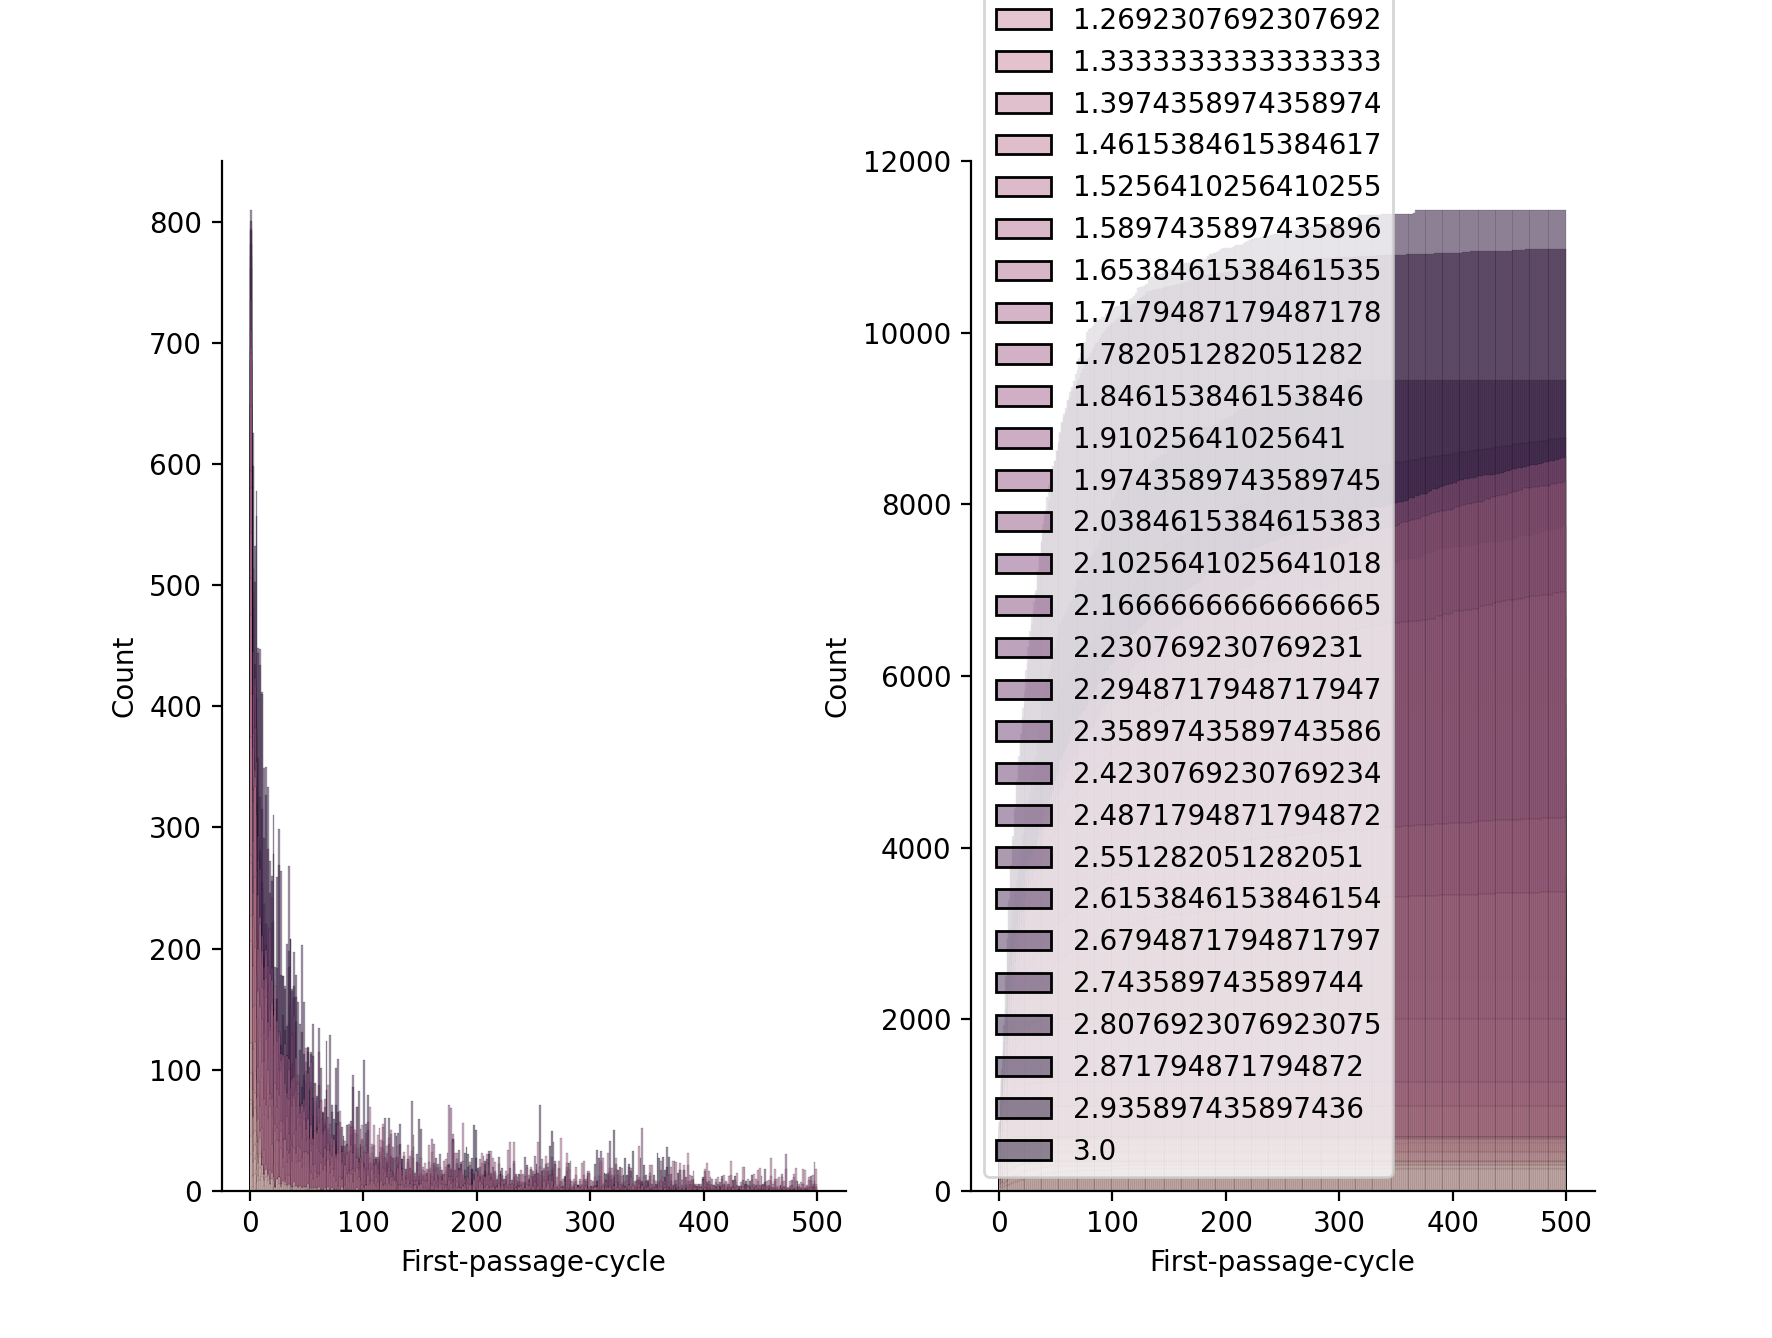

In [32]:
### Plot the first-passage cycle vs different parameters

f, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize=(7, 5))
sns.despine(f)

sns.histplot(data = df_fpt, x = 'First-passage-cycle', hue = parameter, stat = 'count', ax = ax0, legend = False)
sns.histplot(data = df_fpt, x = 'First-passage-cycle', hue = parameter, stat = 'count', ax = ax1, cumulative=True, legend = 'brief')

plt.show()